In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from lightgbm import LGBMRegressor
import lightgbm 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor


import re
import datetime


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [104]:
def point_test(model, df):
    df.loc[:,'predicted_score_own'] = model.predict(df[features])

    max_pred = df.groupby(['week', 'position', 'playerid_own'])[['predicted_score_own']].mean()
    max_pred = max_pred.groupby(['week', 'position'])[['predicted_score_own']].max()
    max_pred = max_pred.reset_index().rename(columns={'predicted_score_own':'max_predicted_score'})
    df = pd.merge(df, max_pred, on=['week', 'position'], how='left')

    picks = df.groupby(['week','position', 'playerid_own'])[['max_score_own', 'score_own', 
                                                                  'predicted_score_own', 'max_predicted_score']].mean().reset_index()
    picks = picks.loc[picks.predicted_score_own == picks.max_predicted_score]

    picks['missed_points'] = picks['max_score_own'] - picks['score_own']
    picks = picks.groupby('week')[['missed_points', 'score_own']].sum().reset_index()

    return picks['score_own'].sum()

In [89]:
data = pd.read_csv('unstacked.csv', index_col='Unnamed: 0')
data.head()

,gameid,date,playerid_own,max_score_own,average_kills_enemytop,average_deaths_enemytop,average_assists_enemytop,average_cs_enemytop,average_score_enemytop,average_firstbloodkill_enemytop,average_triplekills_enemytop,average_quadrakills_enemytop,average_pentakills_enemytop,total_games_enemytop,average_kills_enemyjng,average_deaths_enemyjng,average_assists_enemyjng,average_cs_enemyjng,average_score_enemyjng,average_firstbloodkill_enemyjng,average_triplekills_enemyjng,average_quadrakills_enemyjng,average_pentakills_enemyjng,total_games_enemyjng,average_kills_enemymid,average_deaths_enemymid,average_assists_enemymid,average_cs_enemymid,average_score_enemymid,average_firstbloodkill_enemymid,average_triplekills_enemymid,average_quadrakills_enemymid,average_pentakills_enemymid,total_games_enemymid,average_kills_enemybot,average_deaths_enemybot,average_assists_enemybot,average_cs_enemybot,average_score_enemybot,average_firstbloodkill_enemybot,average_triplekills_enemybot,average_quadrakills_enemybot,average_pentakills_enemybot,total_games_enemybot,average_kills_enemysup,average_deaths_enemysup,average_assists_enemysup,average_cs_enemysup,average_score_enemysup,average_firstbloodkill_enemysup,average_triplekills_enemysup,average_quadrakills_enemysup,average_pentakills_enemysup,total_games_enemysup,average_kills_teamtop,average_deaths_teamtop,average_assists_teamtop,average_cs_teamtop,average_score_teamtop,average_firstbloodkill_teamtop,average_triplekills_teamtop,average_quadrakills_teamtop,average_pentakills_teamtop,total_games_teamtop,average_kills_teamjng,average_deaths_teamjng,average_assists_teamjng,average_cs_teamjng,average_score_teamjng,average_firstbloodkill_teamjng,average_triplekills_teamjng,average_quadrakills_teamjng,average_pentakills_teamjng,total_games_teamjng,average_kills_teammid,average_deaths_teammid,average_assists_teammid,average_cs_teammid,average_score_teammid,average_firstbloodkill_teammid,average_triplekills_teammid,average_quadrakills_teammid,average_pentakills_teammid,total_games_teammid,average_kills_teambot,average_deaths_teambot,average_assists_teambot,average_cs_teambot,average_score_teambot,average_firstbloodkill_teambot,average_triplekills_teambot,average_quadrakills_teambot,average_pentakills_teambot,total_games_teambot,score_own,average_kills_teamsup,average_deaths_teamsup,average_assists_teamsup,average_cs_teamsup,average_score_teamsup,average_firstbloodkill_teamsup,average_triplekills_teamsup,average_quadrakills_teamsup,average_pentakills_teamsup,total_games_teamsup,position
0,ESPORTSTMNT01/1031941,2019-01-19 09:53:50,oe:player:9405c3aff9112c3c60d03b94792877d,34.675,2.375000,1.640625,4.312500,324.125000,20.716875,0.031250,0.031250,0.000000,0.0,64.0,1.875000,1.359375,6.671875,181.640625,21.554688,0.156250,0.000000,0.000000,0.0,64.0,3.400000,0.960000,4.980000,358.580000,26.731600,0.040000,0.120000,0.020000,0.0,50.0,2.828125,1.125000,5.187500,373.687500,25.520625,0.093750,0.062500,0.000000,0.000000,64.0,0.971014,1.681159,7.130435,60.014493,16.953913,0.130435,0.0,0.0,0.0,69.0,1.775641,2.378205,4.301282,297.775641,17.750385,0.102564,0.012821,0.00641,0.0,156.0,2.036364,1.854545,3.927273,163.818182,15.858182,0.236364,0.0,0.0,0.0,55.0,2.222222,1.777778,3.543210,354.555556,19.288642,0.074074,0.037037,0.000000,0.0,81.0,1.000000,2.000000,1.000000,296.000000,8.920000,0.000000,0.000000,0.000000,0.000000,2.0,0.80,0.000000,2.500000,3.000000,18.500000,3.870000,0.000000,0.0,0.0,0.0,2.0,bot
1,ESPORTSTMNT01/1031972,2019-01-19 11:38:58,oe:player:9573154ad8bc9459b4c0d940315054f,34.675,1.764331,2.388535,4.280255,297.363057,17.654268,0.101911,0.012739,0.006369,0.0,157.0,2.017857,1.821429,3.857143,163.357143,15.677857,0.232143,0.000000,0.000000,0.0,56.0,2.195122,1.792683,3.500000,353.414634,19.080488,0.073171,0.036585,0.000000,0.0,82.0,2.444444,2.185185,4.000000,347.555556,20.358519,0.000000,0.037037,0.037037,0.037037,27.0,0.422222,1.955556,3.977778,56.111111,8.477778,0.044444,0.0,0.0,0.0,45.0,2.369231,1.630769,4.276923,3

In [90]:
leagues = pd.read_csv('ml_data.csv')
leagues = leagues[['gameid', 'league']].drop_duplicates()

data = pd.merge(data, leagues, on='gameid', how='left')

C:\Users\IsDan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [91]:
data.loc[:,'date'] = pd.to_datetime(data.date)
data['year'] = data.date.dt.isocalendar()['year']
data['week'] = data.date.dt.isocalendar()['week']

In [92]:
oe = OrdinalEncoder()
data['position'] = oe.fit_transform(data[['position']])

In [93]:
training = data[data.year != 2022]
testing = data[(data.year == 2022) & (data.league=='LEC')]


In [94]:
targets = list(data.filter(regex=("^score.*")).columns)
unused = list(data.filter(regex=("^max.*|^playerid")).columns)
features = [x for x in data.columns if x not in (targets + unused + ['date', 'gameid', 'league', 'year', 'week'])]

X = training[features]
y = training[targets[0]]


In [95]:
high_score = y.quantile(q=0.75)

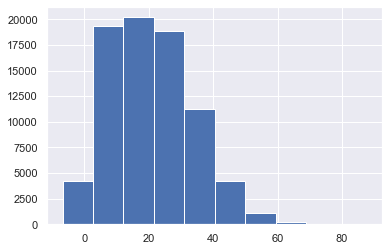

In [96]:
# distribution of target variable
h = plt.hist(y)

In [97]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

In [98]:
### Plotting helper functions

def plot_residual_distribution(model):
    """
    Density plot of residuals (y_true - y_pred) for testation set for given model 
    """
    ax = sns.distplot(y_valid - model.predict(X_valid), hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")
    title = ax.set_title('Kernel density of residuals', size=15)

def plot_scatter_pred_actual(model):
    """
    Scatter plot of predictions from given model vs true target variable from testation set
    """
    ax = sns.scatterplot(x=model.predict(X_valid), y = y_valid)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Actuals')
    title = ax.set_title('Actual vs Prediction scatter plot', size=15)   

## Random Forest Testing

In [16]:
# basic random forest regressor with mse as criterion to measure the quality of split

rf = RandomForestRegressor(n_estimators=50, oob_score=True, random_state=33)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, oob_score=True, random_state=33)

C:\Users\IsDan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


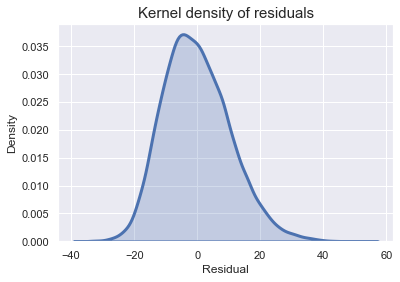

In [19]:
# distribution of residual
plot_residual_distribution(rf)

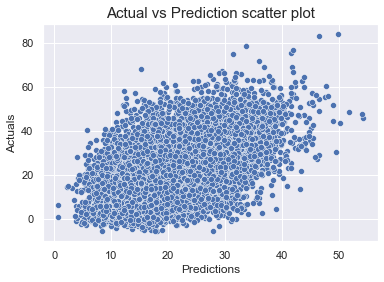

In [21]:
plot_scatter_pred_actual(rf)

In [23]:
print(f"MSE is {mean_squared_error(y_valid, rf.predict(X_valid))}")

MSE is 114.11681341994286


## Default LightGBM

### LightGBM default:MSE

In [99]:
# make new model on new value
gbm = lightgbm.LGBMRegressor(random_state=33)
gbm.fit(X_train,y_train)

LGBMRegressor(random_state=33)

C:\Users\IsDan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


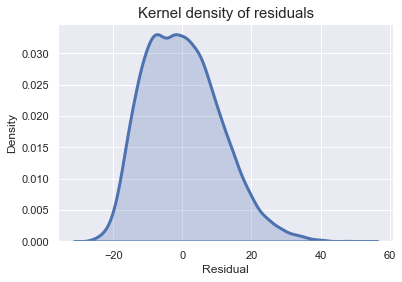

In [100]:
# distribution of residual
plot_residual_distribution(gbm)

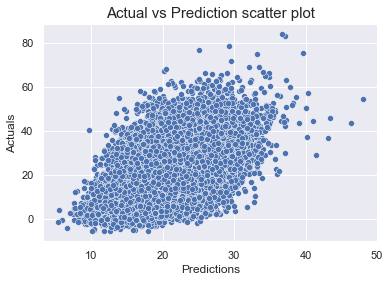

In [101]:
plot_scatter_pred_actual(gbm)

In [102]:
print(f"MSE is {mean_squared_error(y_valid, gbm.predict(X_valid))}")

MSE is 120.75584639890995


In [105]:
point_test(gbm, testing)

C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


1132.0266666666666

### LightGBM default: MSE + early stopping

In [106]:
# make new model on new value
# 'regression' is actually also the default objective for LGBMRegressor

gbm2 = lightgbm.LGBMRegressor(objective='regression',
                              random_state=33,
                              early_stopping_rounds = 10,
                              n_estimators=10000
                             )

gbm2.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='l2',  # also the default
    verbose=False,
)

C:\Users\IsDan\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


LGBMRegressor(early_stopping_rounds=10, n_estimators=10000,
              objective='regression', random_state=33)

C:\Users\IsDan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


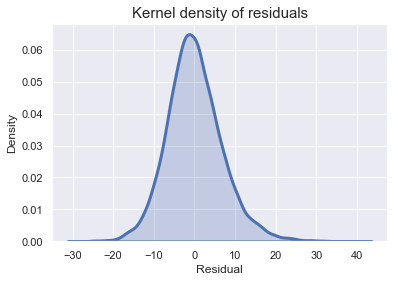

In [107]:
# distribution of residual
plot_residual_distribution(gbm2)

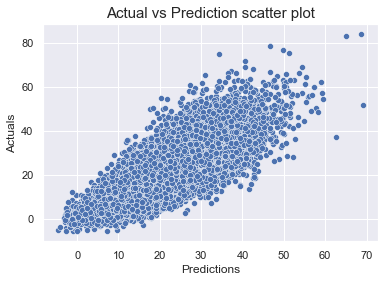

In [108]:
plot_scatter_pred_actual(gbm2)

In [109]:
print(f"MSE is {mean_squared_error(y_valid, gbm2.predict(X_valid))}")

MSE is 47.802631041158364


In [110]:
point_test(gbm2, testing)

C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


835.94

### Assymetric Custom Loss

In [155]:
def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")

    grad = np.where(y_true<high_score, np.where(residual<0, -2*10.0*residual, -2*residual),np.where(residual>=0, -2*10.0*residual, -2*residual))
    hess = np.where(y_true<high_score, np.where(residual<0, 2*10.0, 2.0),np.where(residual>=0, 2*10.0, 2.0))

    return grad, hess

def custom_asymmetric_eval(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(y_true < high_score, np.where(residual<0,(residual**2)*10.0, residual**2), np.where(residual>=0,(residual**2)*10.0, residual**2)) 
    return "custom_asymmetric_eval", np.mean(loss), False

### LightGBM custom objective

In [156]:
# make new model on new value
gbm3 = lightgbm.LGBMRegressor(random_state=33)
gbm3.set_params(**{'objective': custom_asymmetric_objective}, metrics = ["mse", 'mae'])

gbm3.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='l2',
    verbose=False,
)

LGBMRegressor(metrics=['mse', 'mae'],
              objective=<function custom_asymmetric_objective at 0x000001FEC0C55280>,
              random_state=33)

C:\Users\IsDan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


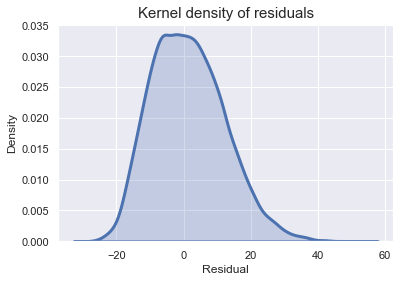

In [157]:
# distribution of residual
plot_residual_distribution(gbm3)

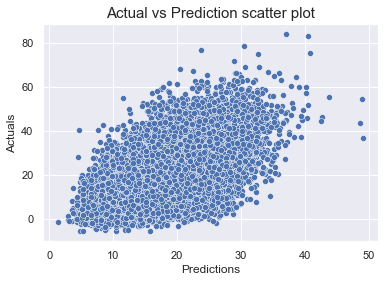

In [158]:
plot_scatter_pred_actual(gbm3)

In [159]:
print(f"MSE is {mean_squared_error(y_valid, gbm3.predict(X_valid))}")

MSE is 120.20148946996892


In [160]:
point_test(gbm3, testing)

C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


1106.62

In [161]:
# make new model on new value
gbm4 = lightgbm.LGBMRegressor(random_state=33,
                              early_stopping_rounds = 10,
                              n_estimators=10000
                             )

gbm4.set_params(**{'objective': "regression"}, metrics = ["mse", 'mae'])

gbm4.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=custom_asymmetric_eval,
    verbose=False,
)

C:\Users\IsDan\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


LGBMRegressor(early_stopping_rounds=10, metrics=['mse', 'mae'],
              n_estimators=10000, objective='regression', random_state=33)

C:\Users\IsDan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


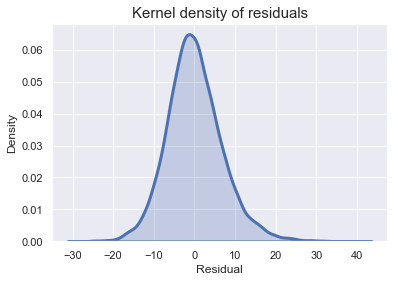

In [162]:
# distribution of residual
plot_residual_distribution(gbm4)

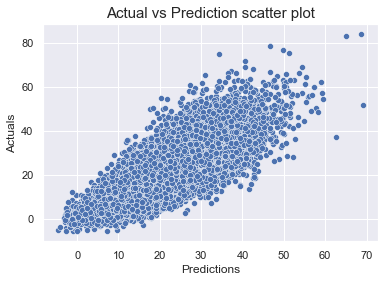

In [163]:
plot_scatter_pred_actual(gbm4)

In [164]:
print(f"MSE is {mean_squared_error(y_valid, gbm4.predict(X_valid))}")

MSE is 47.802631041158364


In [165]:
point_test(gbm4, testing)

C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


835.94

In [166]:
# make new model on new value
gbm5 = lightgbm.LGBMRegressor(random_state=33,
                              early_stopping_rounds = 10,
                              n_estimators=10000
                             )

gbm5.set_params(**{'objective': custom_asymmetric_objective}, metrics = ["mse", 'mae'])

gbm5.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="l2",
    verbose=False,
)

C:\Users\IsDan\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


LGBMRegressor(early_stopping_rounds=10, metrics=['mse', 'mae'],
              n_estimators=10000,
              objective=<function custom_asymmetric_objective at 0x000001FEC0C55280>,
              random_state=33)

C:\Users\IsDan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


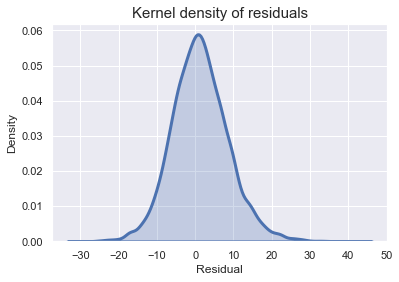

In [167]:
# distribution of residual
plot_residual_distribution(gbm5)

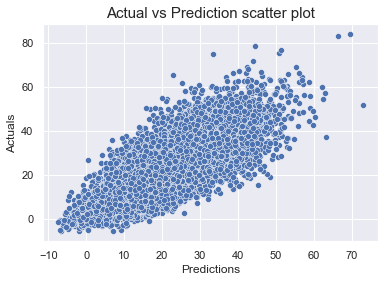

In [168]:
plot_scatter_pred_actual(gbm5)

In [169]:
print(f"MSE is {mean_squared_error(y_valid, gbm5.predict(X_valid))}")

MSE is 56.39666547464006


In [170]:
point_test(gbm5, testing)

C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


900.98

In [171]:
# make new model on new value
gbm6 = lightgbm.LGBMRegressor(random_state=33,
                              early_stopping_rounds = 10,
                              n_estimators=10000
                             )

gbm6.set_params(**{'objective': custom_asymmetric_objective}, metrics = ["mse", 'mae'])

gbm6.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=custom_asymmetric_eval,
    verbose=False,
)

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


C:\Users\IsDan\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMRegressor(early_stopping_rounds=10, metrics=['mse', 'mae'],
              n_estimators=10000,
              objective=<function custom_asymmetric_objective at 0x000001FEC0C55280>,
              random_state=33)

C:\Users\IsDan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


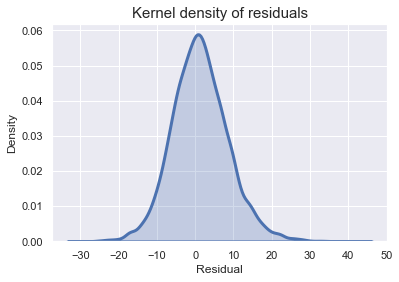

In [172]:
# distribution of residual
plot_residual_distribution(gbm6)

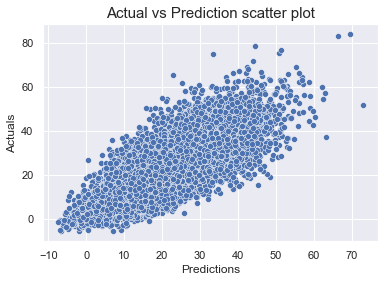

In [173]:
plot_scatter_pred_actual(gbm6)

In [174]:
print(f"MSE is {mean_squared_error(y_valid, gbm6.predict(X_valid))}")

MSE is 56.39666547464006


In [175]:
point_test(gbm6, testing)

C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


900.98

### testing

In [176]:
point_test(rf, testing)

C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


1088.0733333333333